<a href="https://colab.research.google.com/github/rdesarz/zoo/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

# Check for Tensorflow version
print(tf.__version__)

# Check if there is an existing GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.0
Found GPU at: /device:GPU:0


In [2]:
# We use the CIFAR-10 datasets for this example
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

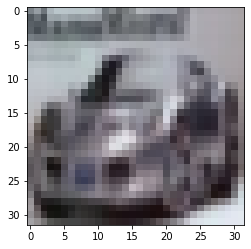

In [4]:
image_index = np.random.randint(low=0, high = train_images.shape[0])
plt.imshow(train_images[image_index])

In [5]:
# Processing function
def process_image(image, label, shuffle=False, augment=False):
  image=tf.image.per_image_standardization(image)
  image=tf.image.resize(image,(64,64))

  return image, label


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_ds_size = tf.data.experimental.cardinality(test_dataset).numpy()

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])


train_dataset=(train_dataset
          .map(process_image)
          .map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=256,drop_remainder=True))
test_dataset=(test_dataset
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=256,drop_remainder=True))

In [8]:
from keras.layers import Conv2D, BatchNormalization, Activation, Add

def conv2(x, downsample=False, conv_skip=False):
    """
    Residual block
    """
    # Create skip connection
    x_skip = x  
    
    first_layer_strides = (2, 2) if downsample else (1, 1)

    # Perform the original mapping
    x = Conv2D(64, kernel_size=(1, 1), strides=first_layer_strides, padding="valid")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(256, kernel_size=(1, 1), strides=(1,1), padding="valid")(x)
    x = BatchNormalization(axis=3)(x)

    if conv_skip:
        x_skip = Conv2D(filters=256, kernel_size=(1, 1), strides=first_layer_strides,
                        padding="same")(x_skip)
        x_skip = BatchNormalization(axis=3)(x_skip)

    # Add the skip connection to the regular mapping
    x = Add()([x, x_skip])

    # Nonlinearly activate the result
    x = Activation("relu")(x)

    # Return the result
    return x


def conv3(x, downsample=False, conv_skip=False):
    """
    Residual block
    """
    # Create skip connection
    x_skip = x  

    first_layer_strides = (2, 2) if downsample else (1, 1)
    
    # Perform the original mapping
    x = Conv2D(128, kernel_size=(1, 1), strides=first_layer_strides, padding="valid")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1,1), padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(512, kernel_size=(1, 1), strides=(1,1), padding="valid")(x)
    x = BatchNormalization(axis=3)(x) 

    if conv_skip:
        x_skip = Conv2D(filters=512, kernel_size=(1, 1), strides=first_layer_strides,
                        padding="same")(x_skip)
        x_skip = BatchNormalization(axis=3)(x_skip)

    # Add the skip connection to the regular mapping
    x = Add()([x, x_skip])

    # Nonlinearly activate the result
    x = Activation("relu")(x)  

    # Return the result
    return x

def conv4(x, downsample=False, conv_skip=False):
    """
    Residual block
    """
    # Create skip connection
    x_skip = x  

    first_layer_strides = (2, 2) if downsample else (1, 1)
    
    # Perform the original mapping
    x = Conv2D(256, kernel_size=(1, 1), strides=first_layer_strides, padding="valid")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(256, kernel_size=(3, 3), strides=(1,1), padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(1024, kernel_size=(1, 1), strides=(1,1), padding="valid")(x)
    x = BatchNormalization(axis=3)(x) 

    if conv_skip:
        x_skip = Conv2D(filters=1024, kernel_size=(1, 1), strides=first_layer_strides,
                        padding="same")(x_skip)
        x_skip = BatchNormalization(axis=3)(x_skip)

    # Add the skip connection to the regular mapping
    x = Add()([x, x_skip])

    # Nonlinearly activate the result
    x = Activation("relu")(x)  

    # Return the result
    return x

def conv5(x, downsample=False, conv_skip=False):
    """
    Residual block
    """
    # Create skip connection
    x_skip = x  

    first_layer_strides = (2, 2) if downsample else (1, 1)
    
    # Perform the original mapping
    x = Conv2D(512, kernel_size=(1, 1), strides=first_layer_strides, padding="valid")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(512, kernel_size=(3, 3), strides=(1,1), padding="same")(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(2048, kernel_size=(1, 1), strides=(1,1), padding="valid")(x)
    x = BatchNormalization(axis=3)(x) 


    if conv_skip:
       x_skip = Conv2D(filters=2048, kernel_size=(1, 1), strides=first_layer_strides,
                       padding="same")(x_skip)
       x_skip = BatchNormalization(axis=3)(x_skip)

    # Add the skip connection to the regular mapping
    x = Add()([x, x_skip])

    # Nonlinearly activate the result
    x = Activation("relu")(x)  

    # Return the result
    return x


In [9]:
from keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense

def model_base():
    # Define model structure
    # logits are returned because Softmax is pushed to loss function.
    inputs = Input(shape=(64, 64, 3))
    x = Conv2D(64, kernel_size=(7,7),	strides=(2,2), padding="same")(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # First residual blocks
    x = conv2(x, conv_skip=True)
    x = conv2(x)
    x = conv2(x)

    # Second residual blocks
    x = conv3(x, downsample=True, conv_skip=True)
    x = conv3(x)
    x = conv3(x)
    x = conv3(x)

    # Third residual blocks
    x = conv4(x, downsample=True, conv_skip=True)
    x = conv4(x)
    x = conv4(x)
    x = conv4(x)
    x = conv4(x)
    x = conv4(x)

    # Fourth residual blocks
    x = conv5(x, downsample=True, conv_skip=True)
    x = conv5(x)
    x = conv5(x)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    return inputs, outputs

In [10]:
# Get model base
inputs, outputs = model_base()

# Initialize and compile model
model = tf.keras.Model(inputs, outputs, name="ResNet50")
model.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.0001)

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    validation_freq=1,
    callbacks=[reduce_lr]
)

Epoch 1/100
195/195 [==============================] - 162s 557ms/step - loss: 3.3057 - accuracy: 0.1930 - val_loss: 219.6604 - val_accuracy: 0.1190 - lr: 0.1000
Epoch 2/100
195/195 [==============================] - 133s 551ms/step - loss: 1.9209 - accuracy: 0.3061 - val_loss: 2.0812 - val_accuracy: 0.3186 - lr: 0.1000
Epoch 3/100
195/195 [==============================] - 132s 551ms/step - loss: 1.7066 - accuracy: 0.3778 - val_loss: 1.6806 - val_accuracy: 0.3658 - lr: 0.1000
Epoch 4/100
195/195 [==============================] - 133s 551ms/step - loss: 1.5884 - accuracy: 0.4222 - val_loss: 1.6567 - val_accuracy: 0.4082 - lr: 0.1000
Epoch 5/100
162/195 [=======================>......] - ETA: 16s - loss: 1.5046 - accuracy: 0.4526